In [4]:
from pathlib import Path
import pandas as pd
import woodsort.nwb as nwb 
import pynapple as nap
import spikeinterface.full as si
import warnings
import neuroconv.tools.spikeinterface as nc

In [5]:
### SPECIFY PATHS ### 

data_path = Path('/home/avadher/Data/')
session_name = 'H7113-250604'
meta_name = 'H7100_metadata.xlsx'
analyzer_name = session_name + '_analyzer_mountainsort5'
nwb_path = data_path / 'NWB' / session_name

session_path = list(data_path.rglob(session_name))[0]

# Ignore annoying warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [6]:
### LOAD DATA ###

metadata = nwb.io.read_metadata_excel(data_path / meta_name, session_name, print_output=True)
start_time = nwb.io.get_start_time(session_path)

# load tracking 
tracking = pd.read_csv(session_path / 'TrackingProcessed.csv',index_col=0, header=0)
pos = nap.TsdFrame(tracking[["x", "y"]])
hd = nap.Tsd(tracking['hd'])
epochs = pd.read_csv(session_path / 'EpochTimestamps.csv', header=0)

# get probe mapping
probe_mapping = pd.read_csv(session_path / 'ChannelMapping.csv',index_col=0, header=0)

# add probe 



{'epoch': {'1': 'wake', '2': 'sleep', '3': 'wake_cue_rot'},
 'file': {'experiment_description': 'Reorientation in the head-direction system',
          'experimenter': 'Narayanan, Trisha',
          'institution': 'University of Edinburgh',
          'lab': 'Wood/Dudchenko lab',
          'name': 'H7113-250604',
          'protocol': 'day1',
          'session_description': 'Cue rotations (45, 90, 135, 180 deg)'},
 'probe': [{'description': '2x32-channels, 25 um channel spacing, implanted at 10 deg angle. '
                           'Channels sorted top to bottom of shank.',
            'id': 1,
            'location': 'left postsubiculum',
            'nshanks': 2,
            'step': 25,
            'type': 'Cambridge Neurotech H7 probe'}],
 'subject': {'dob': 250228, 'genotype': 'WT', 'line': 'Fmr1', 'sex': 'M', 'stock_id': 1906344}}

Start time from sync_messages.txt: 2025-06-04 14:46:12.720000+01:00


In [8]:
### NWB ### 

#Create NWB file
nwbfile = nwb.convert.create_nwb_file(metadata, start_time)

# Add units
nwbfile = nwb.convert.add_units_spikeinterface(nwbfile, session_path / analyzer_name)

# Add tracking
nwbfile = nwb.convert.add_tracking(nwbfile, pos, hd)

# Add epochs
nwbfile = nwb.convert.add_epochs(nwbfile, epochs, metadata)

# Save NWB file
nwbfile = nwb.convert.save_nwb_file(nwbfile, nwb_path, session_name)

# Load to check
data = nwb.convert.load_nwb_file(nwb_path, session_name)



Creating NWB file and adding metadata...
Adding SpikeInterface units and metrics to the NWB file...


/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


noise_level (workers: 12 processes):   0%|          | 0/20 [00:00<?, ?it/s]

calculate_pc_metrics:   0%|          | 0/3 [00:00<?, ?it/s]

Adding tracking to NWB file...
Adding epochs to NWB file...
Saving NWB file...
Created directory: /home/avadher/Data/NWB/H7113-250604
Done!
H7113-250604
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys           │ Type        │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units          │ TsGroup     │
│ epochs         │ IntervalSet │
│ position       │ TsdFrame    │
│ head-direction │ Tsd         │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙


0      2
1      3
2      3
3      3
4      4
      ..
73    62
74    64
75    59
76    52
77     4
Name: extremum_channel, Length: 78, dtype: int64


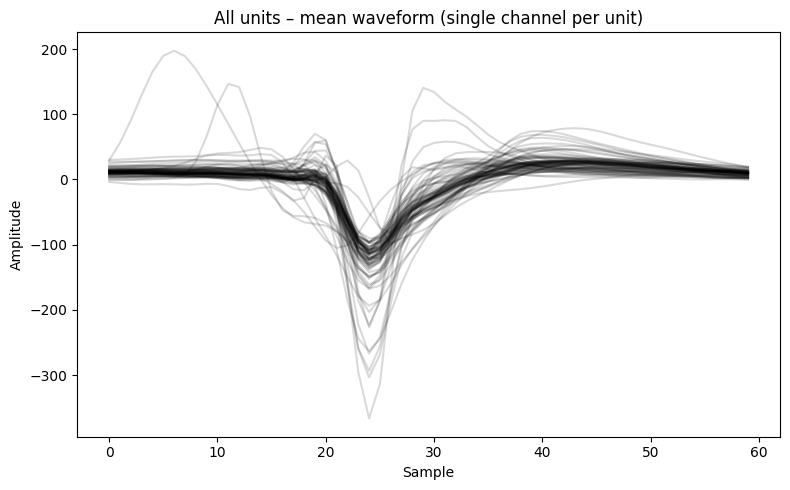

In [5]:

print(data['units']["extremum_channel"])
wf = data.nwb.units['waveform_mean'].data[:]

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for u in range(wf.shape[0]):
    plt.plot(wf[u], color="black", alpha=0.15)

plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("All units – mean waveform (single channel per unit)")
plt.tight_layout()
plt.show()


In [9]:
sorting_analyzer = si.load_sorting_analyzer(session_path / analyzer_name)
nwbfile = nc.add_recording_metadata_to_nwbfile(sorting_analyzer.recording, nwbfile)


AttributeError: 'NoneType' object has no attribute 'devices'

In [22]:
nwbfile = nwb.convert.create_nwb_file(metadata, start_time)

import numpy as np
import spikeinterface.full as si
from neuroconv.tools.spikeinterface import add_sorting_to_nwbfile
import pandas as pd
import json

analyzer_path = session_path / analyzer_name
curation_path=None

print("Adding SpikeInterface units and metrics to the NWB file...")
si.set_global_job_kwargs(n_jobs=12)
sorting_analyzer = si.load_sorting_analyzer(analyzer_path)

# default curation path
if curation_path is None:
    curation_path = analyzer_path / "spikeinterface_gui/curation_data.json"

# apply manual curation
if not curation_path.exists():
    raise FileNotFoundError(
        f"Curation file not found at {curation_path}. "
        "Run SpikeInterface GUI curation first or provide a valid curation_path."
    )

with open(curation_path, "r") as f:
    curation_dict = json.load(f)

sorting_analyzer = si.apply_curation(sorting_analyzer, curation_dict, merging_mode='soft')

# get stuff from analyzer and sorting
add_sorting_to_nwbfile(sorting_analyzer.sorting, nwbfile)

# quality metrics
quality_metrics = sorting_analyzer.get_extension('quality_metrics').get_data()

# template metrics
template_metrics = sorting_analyzer.get_extension('template_metrics').get_data()

# unit locations
probe_locations = sorting_analyzer.get_extension("unit_locations").get_data()

# waveforms
waveforms = sorting_analyzer.get_extension("templates").get_data()
waveforms = np.asarray(waveforms, dtype=np.float32)



############

probe_locations_df = pd.DataFrame()
for coord, data in zip(["x", "y", "z"], probe_locations.T, strict=True):
    probe_locations_df[f"coord_est_{coord}"] = data

# and which channel the extremal template (template with max amp) is on
# --- max channel per unit (0-based index) ---

ext_map = si.get_template_extremum_channel(
    sorting_analyzer, peak_sign="both", outputs="id"
)  # dict: unit_id -> "CH##"

extremum_channel = np.array(
    [int(str(ext_map[uid]).replace("CH", "")) for uid in ext_map],
    dtype=int
)

probe_locations_df["extremum_channel"] = extremum_channel

# now pick only the biggest waveform based on extremum channel

channel_ids = np.array(
    [int(ch.replace("CH", "")) for ch in sorting_analyzer.channel_ids],
    dtype=int
)

chan_id_to_index = {cid: i for i, cid in enumerate(channel_ids)}
extremum_chan_idx = np.array(
    [chan_id_to_index[cid] for cid in extremum_channel],
    dtype=int
)

waveforms = waveforms[:, :, extremum_chan_idx]

print(extremum_chan_idx)


all_unit_metadata = pd.concat(
    [
        probe_locations_df.reset_index(drop=True),
        quality_metrics.reset_index(drop=True),
        template_metrics.reset_index(drop=True),
    ],
    axis=1,
)

# here, we add all that to the nwbfile
for column_name, unit_data in all_unit_metadata.items():

    # force numeric columns to float (pd.NA -> np.nan)
    if unit_data.dtype == "object":
        unit_data = pd.to_numeric(unit_data, errors="coerce")

    nwbfile.units.add_column(
        name=column_name,
        data=unit_data.to_numpy(),
        description=f"{column_name}, computed using spikeinterface.",
    )

nwbfile.units.add_column(
    name="waveform_mean",
    data=waveforms,
    description="Mean waveform template from SpikeInterface (sample x channel).",
)



Creating NWB file and adding metadata...
Adding SpikeInterface units and metrics to the NWB file...


/home/avadher/.conda/envs/woodcode/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/avadher/.conda/envs/woodcode/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/avadher/.conda/envs/woodcode/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


noise_level (workers: 12 processes):   0%|          | 0/20 [00:00<?, ?it/s]

calculate_pc_metrics:   0%|          | 0/3 [00:00<?, ?it/s]

[ 0  1  1  1  2  3  5 26  5  6  7  7  8  9 10 11 12 12 13 15 16 17 18 18
 19 19 20 21 21 22 25 26 27 27 28 29 30 31 32 33 34 35 37 38 38 39 40 41
 42 43 43 44 44 45 32 47 47 48 48 49 48 51 52 53 54 54 34 55 56 57 58 59
 59 60 61 57 50  2]
